In [1]:
import os
import geopandas as gpd
import sys
wos = 'win' in sys.platform
if wos:
    from osgeo import gdal
    from multiprocess import Pool
    from funcs import get_bounds
else:
#     import gdal
    from osgeo import gdal
    from multiprocessing import Pool
import numpy as np
from numba import jit
from tqdm.auto import tqdm
import math
from shapely import geometry
from pathlib import Path
import getpass
import cProfile, pstats
%load_ext snakeviz

In [2]:
tile_size_px = [1000,1000] #x,y
tile_oxerlap_px = 150
output_downsample = 0.5
if wos:
    r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323'
else:
    user = getpass.getuser()
    paths = {'nick':{'output':  r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/tiles',
                     'geotiff': r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323',
                     'data':r'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data'},
             'carlos':{'output':r'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323_output',
                      'geotiff':r'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323',
                      'data':r'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data'}
            }
    
    output_folder = paths[user]['output']
    geotiff_folder = paths[user]['geotiff']
    
input_file_ext = '.tif'
output_compression = 'JPEG'

In [3]:
# !conda install -c conda-forge pygeos
gpd.options.use_pygeos = True
print(gpd.options.use_pygeos)

True


In [4]:
%%time
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(geotiff_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
len(geo_tiff_list) 

CPU times: user 328 µs, sys: 52 µs, total: 380 µs
Wall time: 245 µs


17

In [5]:
if not wos:
    def get_bounds(tif_path):
    #     open file
        data = gdal.Open(tif_path)
    #     grab bounds
        geoTransform = data.GetGeoTransform()
        left = geoTransform[0]
        top = geoTransform[3]
        right = left + geoTransform[1] * data.RasterXSize
        bottom = top + geoTransform[5] * data.RasterYSize
        geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
        return geo_tiff_bounds_dict

In [6]:
geo_tiff_bounds =get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': -34.365234375,
 'left': 116.455078125,
 'bottom': -34.453125,
 'right': 116.54296875,
 'tif_path': '/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323101.tif'}

In [7]:
pool = Pool(3)
with pool:
    list(tqdm(pool.imap(get_bounds,geo_tiff_list[:3]), total=3))

100%|██████████| 3/3 [00:00<00:00, 105.35it/s]


In [8]:
%%time
for i in geo_tiff_list:
    get_bounds(i)

CPU times: user 2.4 ms, sys: 395 µs, total: 2.8 ms
Wall time: 2.54 ms


In [9]:
%%time
# use multiprocessing to extract raster bounds
# interesting when using a small number of geotiffs its is slightly quicker to just run this as a loop
# however once you get over a 100 or so this method is much quicker
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))

# make new array with only bounds 
pure_bounds = []
for geo_tif_bounds in geo_tiff_bounds:
    pure_bounds.append([geo_tif_bounds['top'],geo_tif_bounds['left'],geo_tif_bounds['bottom'],geo_tif_bounds['right']])
# convert into numpy array
pure_bounds_np = np.array(pure_bounds)
# # grab max extents
bound_y_max = float(pure_bounds_np[:,0].max()) #top
bound_x_min = float(pure_bounds_np[:,1].min()) #left
bound_y_min = float(pure_bounds_np[:,2].min()) #bottom
bound_x_max = float(pure_bounds_np[:,3].max()) #right

100%|██████████| 17/17 [00:00<00:00, 1055.20it/s]CPU times: user 24.1 ms, sys: 9.41 ms, total: 33.5 ms
Wall time: 60.7 ms



In [10]:
# open one image to get the pixel size
test_raster = gdal.Open(geo_tiff_list[0])
test_raster_gt =test_raster.GetGeoTransform()
pixel_size_x = test_raster_gt[1]
pixel_size_y = test_raster_gt[5]
print(pixel_size_x,pixel_size_y)

4.487879136029412e-06 -4.487879136029412e-06


In [11]:
# calculate the geographical distance in each direction each tile must be from the last tile
x_move = pixel_size_x*(tile_size_px[0]-tile_oxerlap_px)
y_move = pixel_size_y*(tile_size_px[1]-tile_oxerlap_px)

# calculate the geographical size of each tile
x_tile_size = pixel_size_x*tile_size_px[0]
y_tile_size = pixel_size_y*tile_size_px[1]
print(x_move,y_move)

0.003814697265625 -0.003814697265625


In [12]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

139

In [13]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

93

In [14]:
geo_tiff_bounds[0]['top']

-34.365234375

In [15]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     loop over each geotiff
    intersecting_geotiffs = set()
    
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [16]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_tile_size
    tile_left = bound_x_min

    for col in range(0,number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_tile_size
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col}
            tile_polygon_list.append(polygon)
    return tile_polygon_list


In [17]:
%%time
tile_polygon_list = []
for row in range(0,number_of_rows):
    tile_polygon_list.append(make_polygons(row))

CPU times: user 183 ms, sys: 8.28 ms, total: 191 ms
Wall time: 194 ms


In [18]:
%%time
# multiprocess making polygons
with Pool() as pool:
    tile_polygon_list = pool.map(make_polygons, range(0,number_of_rows))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())

CPU times: user 160 ms, sys: 31.9 ms, total: 192 ms
Wall time: 257 ms


In [19]:
tile_polygon_list[0]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7fdcef207a00>,
 'intersect': {'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323022.tif'},
 'row': 0,
 'col': 0}

In [20]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs='EPSG:4326')
del polygon_tiles_gpd['intersect']

CPU times: user 22.3 ms, sys: 3.72 ms, total: 26 ms
Wall time: 29 ms


<AxesSubplot:>

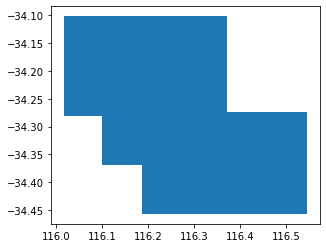

In [21]:
polygon_tiles_gpd.plot()

In [22]:
if not wos:
    polygon_tiles_gpd.to_file(f'{paths[user]["data"]}/output.gpkg', driver="GPKG")
else:
    polygon_tiles_gpd.to_file(r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323\\output.gpkg', driver="GPKG")    



In [23]:
tile_polygon_list[46]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7fdcef2b2b80>,
 'intersect': {'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323023.tif',
  '/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323032.tif'},
 'row': 0,
 'col': 46}

In [24]:
# loop over each geotiff
# for geotiff in tqdm(geo_tiff_with_tiles):
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extention
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    for tile in geotiff[1]:
        time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(time_geometry.bounds)[3]
        bottom = list(time_geometry.bounds)[1]
        left = list(time_geometry.bounds)[0]
        right =list(time_geometry.bounds)[2]
        
#         make row folder path
        output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
        Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '_'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             print('yes')

        export_file_path = os.path.join(output_row_folder,export_file_name)

#     clip the data
#         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
        tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)
    
        translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                 ,creationOptions=['COMPRESS='+output_compression])
        
        tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
#     close the tile
        tile_clip = None
#         break

    

In [25]:
%%time
geo_tiff_with_tiles = []
# make a list of which tiles are within which geotiffs
# loop over each geotiff
for geo_tiff in tqdm(geo_tiff_list):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             we count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'incomplete':incomplete})
    geo_tiff_with_tiles.append([geo_tiff,tiles_inside_geo_tiff])   

100%|██████████| 17/17 [00:00<00:00, 611.55it/s]CPU times: user 26.9 ms, sys: 148 µs, total: 27 ms
Wall time: 34.6 ms



In [26]:
gtwt = {k:v for k,v in geo_tiff_with_tiles}             # Dictionary that resembles geo_tiff_with_tiles
gtwt_keys = {i:k for i,k in enumerate(gtwt.keys())}     # Keys that hold tile_id (incremental int) to tilepath
chip_count = sum( len(v) for v in list(gtwt.values()))  # Confirm total count of chips
# _ = [ print(len(shape_list)) for shape_list in gtwt.values() # Individual count check
chip_count

10426

In [27]:
gtwt_keys[0]

'/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323101.tif'

In [28]:
%%time
# make dictionary form geo_tiffs_with_tiles --  key is (tile_key, tile_chip_key), both zero-based int
#                                               val is {'geometry','row','col','incomplete'} (chip {})
def get_dict(geoTifWithTiles):
    d = {}
    gtwt = {k:v for k,v in geoTifWithTiles}
    gtwt_keys = {i:k for i,k in enumerate(gtwt.keys())}
    chip_count = sum( len(v) for v in list(gtwt.values()))
    ixn_keys = [[(ik,nk) for nk,_ in enumerate(gtwt[ gtwt_keys[ik] ])] for ik in tuple(gtwt_keys.keys())]
    dummy_dict = {}
    for inkl, nl in zip( ixn_keys,gtwt.values() ):
        # print(f'associate members of {nl} to {inkl}')
        for ink,n in zip(inkl,nl):
            # print(f'{ink} <-- {n}')
            d[ink] = n
    return d
geo_dict = get_dict(geo_tiff_with_tiles)

CPU times: user 3.3 ms, sys: 0 ns, total: 3.3 ms
Wall time: 3.31 ms


In [29]:
tiles_md = {k:[] for k,v in geo_dict.items()}
gtwt_basenames = {}
for k, geotiff in gtwt_keys.items():
    geo_tiff_filename = os.path.basename(geotiff).replace(input_file_ext,'')
    gtwt_basenames[k] = geo_tiff_filename
# md_template = {k:v for k,v in zip(['out','gdal_ds','to'],[None]*3)}
tiles_md = {k:[] for k,v in geo_dict.items()}
# populate pre-generated dict with 
# value will be (outpath, gdal_dataset translate_option)
# gdal translate receives export_fp, geotiff_open or path, translate options w/ tile_clip_string
def prep_tiles_md(geotiff):
    key, tile = geotiff
    (tile_key, node_key) = key
    time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
    top = list(time_geometry.bounds)[3]
    bottom = list(time_geometry.bounds)[1]
    left = list(time_geometry.bounds)[0]
    right =list(time_geometry.bounds)[2]
    
#         make row folder path
    output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
    Path(output_row_folder).mkdir(parents=True, exist_ok=True)
    export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
    
#         check if tile is incomplete if so append the getiff name so that it is unique
    if tile['incomplete']:
        append_name = '_'+gtwt_basenames[tile_key]+'_incomplete.tif'
        export_file_name = export_file_name.replace('.tif',append_name)
#             print('yes')

    export_file_path = os.path.join(output_row_folder,export_file_name)

#     clip the data
#         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
    # tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)
    tile_clip_string = f'{left} {top} {right} {bottom}'
    # translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                # ,creationOptions=['COMPRESS='+output_compression])

    # paired-key dict holds args for translate command
    # tiles_md[key] = [export_file_path, open_gdal[tile_key], translate_options] # pool: cannot pickle SwigPy Object
    tiles_md[key] = [export_file_path, gtwt_keys[tile_key], tile_clip_string]

In [30]:
%%time
# This is meant to save values to cut_tiles while running in multithread, but doesn't -- use next block --- _ = [ prep_tiles_md(item) for item in list(geo_dict.items()) ]
def prep():
    pool = Pool()
    with pool:
        tuple(tqdm(pool.imap(prep_tiles_md,tuple( geo_dict.items() )), total=len(geo_tiff_with_tiles)))

prep()

10426it [00:01, 8026.93it/s]CPU times: user 860 ms, sys: 214 ms, total: 1.07 s
Wall time: 1.35 s



In [31]:
%%time
_ = [ prep_tiles_md(item) for item in list(geo_dict.items()) ]

CPU times: user 1.57 s, sys: 68.4 ms, total: 1.64 s
Wall time: 1.69 s


In [38]:
# get bash gdal string of parameters from chip
def get_arg_string(args_ls):
    out, src, tcs = args_ls
    arg_str = f'-projwin {tcs} -co "COMPRESS"={output_compression} -co "NUM_THREADS"=ALL_CPUS {src} {out}'
    return arg_str
arg_str = get_arg_string(tiles_md[(0,0)])

In [36]:
# These iterate through all chips in one loop
tiles_ls = list(tiles_md.values())
tiles_md[(0,0)]     # dictionary to access chip arguments for gdal.Translate() (given tile i chip j)
tiles_ls[0]         # list of each chip's string arguments for gdal.Translate() 

10426

In [39]:
# Re-create geo_tiff_with_tiles as list of tiles, each associated with its list of chips' string arguments for gdal.Translate()
args_per_tile = [[] for _ in range(len(gtwt))]
arg_ls_per_tile = [[] for _ in range(len(gtwt))]
len(args_per_tile)

for (tk,ik), args in tiles_md.items():
    arg_ls_per_tile[tk].append(args)
    args_per_tile[tk].append(get_arg_string(args))

print('As list -- to be used with python gdal') #[['src', ['out_path', 'src', 'left top right bottom'], ... ]
print(arg_ls_per_tile[0][0])
print('As string -- to be used with bash gdal') #[['src', "-projwin left top right bottom -co "COMPRESS"=JPEG -co "NUM_THREADS"=ALL_CPUS 'src' 'out'"], ...]
print(args_per_tile[0][0])


As list -- to be used with python gdal
['/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323_output/68/68_115_VIVID_Landgate_20190910_112102323101_incomplete.tif', '/home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323101.tif', '116.45431518554688 -34.3609619140625 116.45880306468291 -34.36544979319853']
As string -- to be used with bash gdal
-projwin 116.45431518554688 -34.3609619140625 116.45880306468291 -34.36544979319853 -co "COMPRESS"=JPEG -co "NUM_THREADS"=ALL_CPUS /home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323101.tif /home/carlos/Pictures/vivid/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323_output/68/68_115_VIVID_Landgate_20190910_112102323101_incomplete.tif


In [40]:
# cut tiles from prepared list of args -- to be used with iterable of gdal_translate arg lists [out, src, tcs] e.g. tiles_ls or sublist of arg_ls_per_tile
def cut_tiles_from_md(gt_args):
    out, src, tcs = gt_args
    to = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tcs)
                                ,creationOptions=['COMPRESS='+output_compression,'','NUM_THREADS=ALL_CPUS'])
    tile_clip = gdal.Translate(out, src, options=to)
    tile_clip = None   

In [41]:
# cut tiles from prepared list of args -- to be used with arg_ls_per_tile
def cut_tiles_from_md_forloop(gt_args_ls):
    for gt_args in gt_args_ls:
        cut_tiles_from_md(gt_args)

In [43]:
# cut tiles from prepared list of args, iterated in order -- to be used with args_per_tile ## TODO: Test numba prange?
def cut_tiles_from_md_dict(N=None):
    pk = tuple(tiles_md.keys())
    for t,n in pk:
        cut_tiles_from_md(tiles_md[t,n])

In [44]:
def cut_tiles_bash(gt_args):            # to be used with tiles_ls
    out, src, tcs = gt_args
    arg_str = f'-projwin {tcs} -co "COMPRESS"={output_compression} -co "NUM_THREADS"=ALL_CPUS {src} {out}'
    !gdal_translate $arg_str

In [45]:
def cut_tiles_bash_forlooped(args_list): # to be used with arg_ls_per_tile
    for args in args_list:
        cut_tiles_bash(args)

In [46]:
def mt_func(f,a):                  # multi_thread tiling function
    pool = Pool()
    with pool:
        list(tqdm(pool.imap(f, a), total=len(a)))

In [47]:
def st_func(f, a, N=None):         # single_thread tiling function
    for md in a[:N]:
        f(md)

In [48]:
def profile_f(test_f,f,a):
    profiler = cProfile.Profile()
    profiler.enable()
    test_f(f,a)
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('tottime')
    return stats

In [ ]:
short_gtwt = lambda N: [[name, tiles[:N]] for [name, tiles] in geo_tiff_with_tiles] # Short version of geo_tiff_with_tiles (up to N tiles per geotiff)
orig = profile_f(mt_func, cut_tiles, short_gtwt(10))                                # Profile original function and save stats
orig.dump_stats(f'{paths[user]["data"]}/original.txt')                  # Optionally dump stats to disk
# %snakeviz orig                                                                    # Optionally visualise with snakeviz

In [ ]:
short_agpt = lambda N: [[name, args[:N]] for [name, args] in arg_ls_per_tile]
prep = profile_f(mt_func, cut_tiles_from_md, short_gtwt(10))                        # Profile original function and save stats
prep.dump_stats(f'{paths[user]["data"]}/py_gdalt_only-looped.txt')                  # Optionally dump stats to disk
# %snakeviz orig                                                                    # Optionally visualise with snakeviz

In [ ]:
%%time
N = 100
for i in range(N):
    arg_str = get_arg_string(tiles_ls[i])
    !gdal_translate --config GDAL_CACHEMAX 512 $arg_str
%%time
for i in range(N):
    arg_str = get_arg_string(tiles_ls[i])
    os.popen(f'gdal_translate --config GDAL_CACHEMAX 512 {arg_str}').readlines()
%%time
for i in range (N):
    cut_tiles_from_md(tiles_md[(0,i)])
%%time
for i in range(600):def get_arg_string(args_ls):
    out, src, tcs = args_ls
    arg_str = f'-projwin {tcs} -co "COMPRESS"={output_compression} -co "NUM_THREADS"=ALL_CPUS {src} {out}'
    return arg_str
    cut_tiles([geo_tiff_with_tiles[0][0],[geo_tiff_with_tiles[0][1][i]]])